In [ ]:
!unzip uma-randomforest-with-nbc.zip

In [ ]:
%cd uma-randomforest-with-nbc/

In [ ]:
# import sys
# sys.path.append('..\\models')

import pandas as pd
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import numpy as np
# from tqdm import tqdm
from tqdm.notebook import tqdm
# from tqdm.contrib.itertools import product
from itertools import product

# from ID3 import ID3
# from NBC_Categorical import NBC_Categorical
# from RandomForestClf import RandomForestClf
# from datasets import get_airline_dataset, get_exams_dataset, get_ecommerce_dataset

from models.ID3 import ID3
from models.NBC_Categorical import NBC_Categorical
from models.RandomForestClf import RandomForestClf
from experiments.datasets import get_exams_dataset, get_ecommerce_dataset, get_airline_dataset

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [ ]:
def cross_validation_score(X, y, model, n_splits=5):
    kf =KFold(n_splits=5, shuffle=True, random_state=42)
    # split()  method generate indices to split data into training and test set.
    acc_scores = []
    f1_scores = []
    for train_index, test_index in kf.split(X, y):
        train_X, train_y = X.loc[train_index,:], y.loc[train_index]
        test_X, test_y = X.loc[test_index, :], y.loc[test_index]
        model.fit(train_X, train_y)
        acc, f1 = model.scores(test_X, test_y)
        acc_scores.append(acc)
        f1_scores.append(f1)
    
    acc_score = round(np.mean(acc_scores), 4)
    f1_score = round(np.mean(f1_scores), 4)
    return acc_score, f1_score

def test_accuracy(X, y, model):
    return model.scores(X, y)

def get_conf_matrix(y_test, y_pred, labels):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.show()

# Plan eksperymentów

Dla każdego zbioru danych:

Budowa lasu losowego z parametrami:
- jaki procent liczby atrybutów jest losowany: 25%, 50%, 75%
- jaki procent przykładów jest losowany: 25%, 50%, 75%
- proporcje liczby ID3 do NBC: 25:75, 50:50, 75:25, 100:0
- liczba klasyfikatorow: 64, 96, 128

Czyli razem 3\*3\*3\*4\*3=324 doswiadczeń powtórzonych 25 razy i uśrednionych

Dla najlepszego znalezionego modelu rysujemy confusion matrix

# Experiment template

In [ ]:
experiment_repetitions = 5
dataset_loadDataset_valMethod = [("e-commerce", get_ecommerce_dataset)]#, ("airline", get_airline_dataset)] # [("exams", get_exams_dataset)] 
model_param_attribute_part = [0.25, 0.5, 0.75]
model_param_instances_per_classifier = [0.25, 0.5, 0.75]
model_param_id3_to_NBC = [[0.25, 0.75], [0.50, 0.50], [0.75, 0.25], [1, 0]]
model_param_num_of_classifiers = [64, 96, 128]


In [ ]:
def experiment(result_file_name, experiment_repetitions, 
               dataset_loadDataset_valMethod, 
               model_param_attribute_part, 
               model_param_instances_per_classifier,
               model_param_id3_to_NBC,
               model_param_num_of_classifiers):


    models_results_df = pd.DataFrame(columns=["model", "accuracy", "f1 score", "dataset", "attribute part", "instances per classifier", "id3 to NBC", "num of classifiers", "acc_scores", "f1_scores", "max_acc", "min_acc", "max_f1", "min_f1"])

    # Parameter Loops
    for dataset_name, load_func in dataset_loadDataset_valMethod:
        print("DATASET:", dataset_name)
        if dataset_name=="airline":
            (X_train, y_train), (X_test, y_test) = get_airline_dataset("train"), get_airline_dataset("test")
        else:
            X, y = load_func()
            
        params_prod = list(product(model_param_attribute_part, 
                                model_param_instances_per_classifier, 
                                model_param_id3_to_NBC, 
                                model_param_num_of_classifiers))
        for m_p_attribute_part,m_p_instances_per_classifier,m_p_id3_to_NBC,m_p_num_of_classifiers in tqdm(params_prod, total=len(params_prod), desc="Parameters variations", position=0):
                                        
            acc_scores = []
            f1_scores = []
            # Experiment repetitions loop
            for i in tqdm(range(experiment_repetitions), total=experiment_repetitions, desc="Experiment repetitions", position=1, leave=False) :
                model = RandomForestClf(n_clf=m_p_num_of_classifiers, clf_ratio=m_p_id3_to_NBC, percent_samples = m_p_instances_per_classifier, percent_attributes=m_p_attribute_part)
                # model = NBC_Categorical()
                if dataset_name=="airline":
                    model.fit(X_train, y_train)
                    acc, f1 = model.scores(X_test, y_test)
                else:
                    acc, f1 = cross_validation_score(X, y, model)
                
                acc_scores.append(acc)
                f1_scores.append(f1)
                
            model_name = f"RandomForestClf"
            final_acc_score = np.mean(acc_scores)
            final_f1_score = np.mean(f1_scores)
            models_results_df.loc[len(models_results_df)] = [model_name, 
                                                             final_acc_score, 
                                                             final_f1_score,
                                                             dataset_name, 
                                                             m_p_attribute_part, 
                                                             m_p_instances_per_classifier, 
                                                             m_p_id3_to_NBC, 
                                                             m_p_num_of_classifiers,
                                                             np.array(acc_scores),
                                                             np.array(f1_scores),
                                                             np.max(acc_scores),
                                                             np.min(acc_scores),
                                                             np.max(f1_scores),
                                                             np.min(f1_scores)]
            
            # models_results_df.to_csv(f"{result_file_name}.csv", index=False)
            
        models_results_df.to_csv(f"{result_file_name}.csv", index=False)
    
    return models_results_df

# Dobieranie parametrów lasu

## 1. Dobieranie model_param_attribute_part

In [ ]:
experiment_repetitions = 1
dataset_loadDataset_valMethod = [("e-commerce", get_ecommerce_dataset)]
model_param_attribute_part = [0.25, 0.5, 0.75]
model_param_instances_per_classifier = [0.5]
model_param_id3_to_NBC = [[0.50, 0.50]]
model_param_num_of_classifiers = [96]

exp1_models_results_df = experiment("exp1-model_param_attribute_part", experiment_repetitions, 
               dataset_loadDataset_valMethod, 
               model_param_attribute_part, 
               model_param_instances_per_classifier,
               model_param_id3_to_NBC,
               model_param_num_of_classifiers)

DATASET: e-commerce


Parameters variations:   0%|          | 0/3 [00:00<?, ?it/s]

Experiment repetitions:   0%|          | 0/1 [00:00<?, ?it/s]

Experiment repetitions:   0%|          | 0/1 [00:00<?, ?it/s]

Experiment repetitions:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
from google.colab import files
files.download( "exp1-model_param_attribute_part.csv" ) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
exp1_models_results_df

,model,accuracy,f1 score,dataset,attribute part,instances per classifier,id3 to NBC,num of classifiers
0,RandomForestClf,0.6712,0.6698,e-commerce,0.25,0.5,"[0.5, 0.5]",96
1,RandomForestClf,0.6902,0.6428,e-commerce,0.50,0.5,"[0.5, 0.5]",96
2,RandomForestClf,0.6965,0.6483,e-commerce,0.75,0.5,"[0.5, 0.5]",96


In [ ]:
experiment_repetitions = 1
dataset_loadDataset_valMethod = [("e-commerce", get_ecommerce_dataset)]
model_param_attribute_part = [0.9, 1]

exp1b_models_results_df = experiment("exp1b-model_param_attribute_part", experiment_repetitions, 
               dataset_loadDataset_valMethod, 
               model_param_attribute_part, 
               model_param_instances_per_classifier,
               model_param_id3_to_NBC,
               model_param_num_of_classifiers)

files.download( "exp1b-model_param_attribute_part.csv" ) 

DATASET: e-commerce


Parameters variations:   0%|          | 0/2 [00:00<?, ?it/s]

Experiment repetitions:   0%|          | 0/1 [00:00<?, ?it/s]

Experiment repetitions:   0%|          | 0/1 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
exp1b_models_results_df

,model,accuracy,f1 score,dataset,attribute part,instances per classifier,id3 to NBC,num of classifiers
0,RandomForestClf,0.6952,0.6487,e-commerce,0.9,0.5,"[0.5, 0.5]",96
1,RandomForestClf,0.6925,0.6435,e-commerce,1.0,0.5,"[0.5, 0.5]",96


In [ ]:
exp1_df = pd.concat([exp1_models_results_df, exp1b_models_results_df])
exp1_df

,model,accuracy,f1 score,dataset,attribute part,instances per classifier,id3 to NBC,num of classifiers
0,RandomForestClf,0.6712,0.6698,e-commerce,0.25,0.5,"[0.5, 0.5]",96
1,RandomForestClf,0.6902,0.6428,e-commerce,0.50,0.5,"[0.5, 0.5]",96
2,RandomForestClf,0.6965,0.6483,e-commerce,0.75,0.5,"[0.5, 0.5]",96
0,RandomForestClf,0.6952,0.6487,e-commerce,0.90,0.5,"[0.5, 0.5]",96
1,RandomForestClf,0.6925,0.6435,e-commerce,1.00,0.5,"[0.5, 0.5]",96


Wybrana wartość: 0.75

## 2. Dobieranie model_param_instances_per_classifier

In [ ]:
experiment_repetitions = 1
dataset_loadDataset_valMethod = [("e-commerce", get_ecommerce_dataset)]
model_param_attribute_part = [0.75]
model_param_instances_per_classifier = [0.25, 0.5, 0.75, 1.0]
model_param_id3_to_NBC = [[0.50, 0.50]]
model_param_num_of_classifiers = [96]

exp2_models_results_df = experiment("exp2-model_param_instances_per_classifier", experiment_repetitions, 
               dataset_loadDataset_valMethod, 
               model_param_attribute_part, 
               model_param_instances_per_classifier,
               model_param_id3_to_NBC,
               model_param_num_of_classifiers)

In [ ]:
exp2_models_results_df

,model,accuracy,f1 score,dataset,attribute part,instances per classifier,id3 to NBC,num of classifiers
0,RandomForestClf,0.6870,0.5934,e-commerce,0.75,0.25,"[0.5, 0.5]",96
1,RandomForestClf,0.6980,0.6497,e-commerce,0.75,0.50,"[0.5, 0.5]",96
2,RandomForestClf,0.7018,0.6534,e-commerce,0.75,0.75,"[0.5, 0.5]",96
3,RandomForestClf,0.7271,0.7260,e-commerce,0.75,1.00,"[0.5, 0.5]",96


In [ ]:
files.download( "exp2-model_param_instances_per_classifier.csv" ) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 3. Dobieranie model_param_id3_to_NBC

In [ ]:
experiment_repetitions = 1
dataset_loadDataset_valMethod = [("e-commerce", get_ecommerce_dataset)] 
model_param_attribute_part = [0.75]
model_param_instances_per_classifier = [1.0]
model_param_id3_to_NBC = [[0.25, 0.75], [0.50, 0.50], [0.75, 0.25], [1, 0]]
model_param_num_of_classifiers = [96]

exp3_models_results_df = experiment("exp3-model_param_id3_to_NBC", experiment_repetitions, 
               dataset_loadDataset_valMethod, 
               model_param_attribute_part, 
               model_param_instances_per_classifier,
               model_param_id3_to_NBC,
               model_param_num_of_classifiers)

In [ ]:
exp3_models_results_df

,model,accuracy,f1 score,dataset,attribute part,instances per classifier,id3 to NBC,num of classifiers
0,RandomForestClf,0.6742,0.6686,e-commerce,0.75,1.0,"[0.25, 0.75]",96
1,RandomForestClf,0.7271,0.7260,e-commerce,0.75,1.0,"[0.5, 0.5]",96
2,RandomForestClf,0.8582,0.8214,e-commerce,0.75,1.0,"[0.75, 0.25]",96
3,RandomForestClf,0.8736,0.8376,e-commerce,0.75,1.0,"[1, 0]",96


In [ ]:
files.download( "exp3-model_param_id3_to_NBC.csv" )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 4. Dobieranie model_param_num_of_classifiers

In [ ]:
experiment_repetitions = 1
dataset_loadDataset_valMethod = [("e-commerce", get_ecommerce_dataset)]
model_param_attribute_part = [0.75]
model_param_instances_per_classifier = [1.0]
model_param_id3_to_NBC = [[0.50, 0.50]]
model_param_num_of_classifiers = [64, 96, 128]

exp4_models_results_df = experiment("exp4-model_param_num_of_classifiers", experiment_repetitions, 
               dataset_loadDataset_valMethod, 
               model_param_attribute_part, 
               model_param_instances_per_classifier,
               model_param_id3_to_NBC,
               model_param_num_of_classifiers)

DATASET: e-commerce


Parameters variations:   0%|          | 0/3 [00:00<?, ?it/s]

Experiment repetitions:   0%|          | 0/1 [00:00<?, ?it/s]

Experiment repetitions:   0%|          | 0/1 [00:00<?, ?it/s]

Experiment repetitions:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
files.download( "exp4-model_param_num_of_classifiers.csv" ) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
exp4_models_results_df

,model,accuracy,f1 score,dataset,attribute part,instances per classifier,id3 to NBC,num of classifiers
0,RandomForestClf,0.7271,0.726,e-commerce,0.75,1.0,"[0.5, 0.5]",64
1,RandomForestClf,0.7271,0.726,e-commerce,0.75,1.0,"[0.5, 0.5]",96
2,RandomForestClf,0.7271,0.726,e-commerce,0.75,1.0,"[0.5, 0.5]",128


### 4b. Dobieranie model_param_num_of_classifiers

In [ ]:
experiment_repetitions = 1
dataset_loadDataset_valMethod = [("e-commerce", get_ecommerce_dataset)]
model_param_attribute_part = [0.75]
model_param_instances_per_classifier = [0.75]
model_param_id3_to_NBC = [[0.50, 0.50]]
model_param_num_of_classifiers = [64, 96, 128]

exp4b_models_results_df = experiment("exp4b-model_param_num_of_classifiers", experiment_repetitions, 
               dataset_loadDataset_valMethod, 
               model_param_attribute_part, 
               model_param_instances_per_classifier,
               model_param_id3_to_NBC,
               model_param_num_of_classifiers)

DATASET: e-commerce


Parameters variations:   0%|          | 0/3 [00:00<?, ?it/s]

Experiment repetitions:   0%|          | 0/1 [00:00<?, ?it/s]

Experiment repetitions:   0%|          | 0/1 [00:00<?, ?it/s]

Experiment repetitions:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
files.download( "exp4b-model_param_num_of_classifiers.csv" ) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
exp4b_models_results_df

,model,accuracy,f1 score,dataset,attribute part,instances per classifier,id3 to NBC,num of classifiers
0,RandomForestClf,0.7003,0.6524,e-commerce,0.75,0.75,"[0.5, 0.5]",64
1,RandomForestClf,0.7007,0.6522,e-commerce,0.75,0.75,"[0.5, 0.5]",96
2,RandomForestClf,0.7008,0.6525,e-commerce,0.75,0.75,"[0.5, 0.5]",128


# Ewaluacja z dobranymi parametrami

## Exams

In [ ]:
experiment_repetitions = 25
dataset_loadDataset_valMethod = [("exams", get_exams_dataset)]#, ("airline", get_airline_dataset)] # [("exams", get_exams_dataset)] 
model_param_attribute_part = [0.75]
model_param_instances_per_classifier = [1.0]
model_param_id3_to_NBC = [[0.50, 0.50], [1, 0]]
model_param_num_of_classifiers = [64]

exp5_models_results_df = experiment("exp5-exams", experiment_repetitions, 
               dataset_loadDataset_valMethod, 
               model_param_attribute_part, 
               model_param_instances_per_classifier,
               model_param_id3_to_NBC,
               model_param_num_of_classifiers)

DATASET: exams


Parameters variations:   0%|          | 0/2 [00:00<?, ?it/s]

Experiment repetitions:   0%|          | 0/25 [00:00<?, ?it/s]

Experiment repetitions:   0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
exp5_models_results_df

,model,accuracy,f1 score,dataset,attribute part,instances per classifier,id3 to NBC,num of classifiers,acc_scores,f1_scores,max_acc,min_acc,max_f1,min_f1
0,RandomForestClf,0.34504,0.267532,exams,0.75,1.0,"[0.5, 0.5]",64,"[0.346, 0.339, 0.342, 0.348, 0.352, 0.343, 0.3...","[0.2771, 0.2586, 0.2709, 0.2732, 0.2796, 0.275...",0.352,0.339,0.2796,0.2454
1,RandomForestClf,0.37400,0.324996,exams,0.75,1.0,"[1, 0]",64,"[0.37, 0.376, 0.38, 0.376, 0.377, 0.372, 0.369...","[0.3243, 0.3316, 0.3285, 0.3273, 0.3261, 0.325...",0.383,0.369,0.3343,0.3153


In [ ]:
from google.colab import files
files.download("exp5-exams.csv" )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

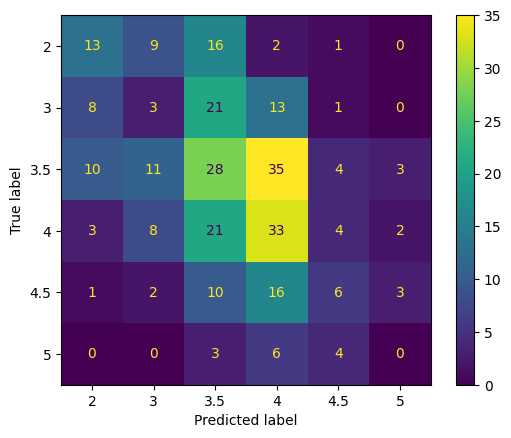

In [ ]:
random_forest = RandomForestClf(n_clf=64, clf_ratio=[0.5, 0.5], percent_samples =1.0, percent_attributes=0.75)
X, y = get_exams_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)

get_conf_matrix(y_test, y_pred, ["2", "3", "3.5", "4", "4.5", "5"])

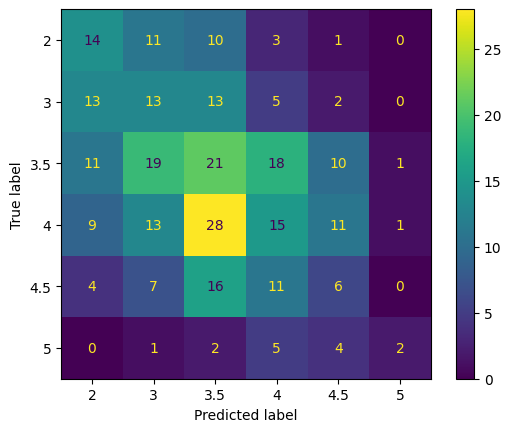

In [ ]:
random_forest = RandomForestClf(n_clf=64, clf_ratio=[1.0, 0.0], percent_samples =1.0, percent_attributes=0.75)
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)

get_conf_matrix(y_test, y_pred, ["2", "3", "3.5", "4", "4.5", "5"])


## Ecommerce

In [ ]:
experiment_repetitions = 5
dataset_loadDataset_valMethod = [("e-commerce", get_ecommerce_dataset)]#, ("airline", get_airline_dataset)] # [("exams", get_exams_dataset)] 
model_param_attribute_part = [0.75]
model_param_instances_per_classifier = [1.0]
model_param_id3_to_NBC = [[0.50, 0.50], [1, 0]]
model_param_num_of_classifiers = [64]

exp6_models_results_df = experiment("exp6-ecommerce", experiment_repetitions, 
               dataset_loadDataset_valMethod, 
               model_param_attribute_part, 
               model_param_instances_per_classifier,
               model_param_id3_to_NBC,
               model_param_num_of_classifiers)

DATASET: e-commerce


Parameters variations:   0%|          | 0/2 [00:00<?, ?it/s]

Experiment repetitions:   0%|          | 0/5 [00:00<?, ?it/s]

Experiment repetitions:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
exp6_models_results_df

,model,accuracy,f1 score,dataset,attribute part,instances per classifier,id3 to NBC,num of classifiers,acc_scores,f1_scores,max_acc,min_acc,max_f1,min_f1
0,RandomForestClf,0.76170,0.72508,e-commerce,0.75,1.0,"[0.5, 0.5]",64,"[0.7545, 0.7673, 0.7678, 0.7547, 0.7642]","[0.7541, 0.7221, 0.7225, 0.7082, 0.7185]",0.7678,0.7545,0.7541,0.7082
1,RandomForestClf,0.90306,0.86210,e-commerce,0.75,1.0,"[1, 0]",64,"[0.9032, 0.9025, 0.9035, 0.9043, 0.9018]","[0.8622, 0.8623, 0.8622, 0.8631, 0.8607]",0.9043,0.9018,0.8631,0.8607


In [ ]:
from google.colab import files
files.download("exp6-ecommerce.csv" )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
experiment_repetitions = 5
dataset_loadDataset_valMethod = [("e-commerce", get_ecommerce_dataset)]#, ("airline", get_airline_dataset)] # [("exams", get_exams_dataset)] 
model_param_attribute_part = [0.75]
model_param_instances_per_classifier = [1.0]
model_param_id3_to_NBC = [[0, 1]]
model_param_num_of_classifiers = [64]

exp7_models_results_df = experiment("exp7-1-ecommerce", experiment_repetitions, 
               dataset_loadDataset_valMethod, 
               model_param_attribute_part, 
               model_param_instances_per_classifier,
               model_param_id3_to_NBC,
               model_param_num_of_classifiers)

DATASET: e-commerce


Parameters variations:   0%|          | 0/1 [00:00<?, ?it/s]

Experiment repetitions:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
exp7_models_results_df

,model,accuracy,f1 score,dataset,attribute part,instances per classifier,id3 to NBC,num of classifiers,acc_scores,f1_scores,max_acc,min_acc,max_f1,min_f1
0,RandomForestClf,0.68426,0.68098,e-commerce,0.75,1.0,"[0, 1]",64,"[0.6842, 0.6838, 0.684, 0.6851, 0.6842]","[0.681, 0.6807, 0.6806, 0.6818, 0.6808]",0.6851,0.6838,0.6818,0.6806


In [ ]:
from google.colab import files
files.download("exp7-1-ecommerce.csv" )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>